# Machine Learning with Tensorflow

Tensorflow (TF) can not only be used for deep learning, but for numerical computations in general. It is specially suited for handling matrices and tensors.

In this notebook we will explore how to use TF for *traditional* machine learning (ML) model, and how it compares to solving the same problem using a deep learning model.

In [1]:
%pylab inline
plt.style.use('seaborn-talk')
import tensorflow as tf

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
1.11.0


## Getting familiar with Tensorflow

TF uses lazy evaluation. When we define an operation, we only create the execution graph for that operation. We need to explicitly *run* the graph to obtain the result.
* TF also supports eager execution in Python, which runs the operations inmediately, but we will not use it in this notebook
* Eager execution is intented for running small tests in an interactive notebook or prompt

In Numpy, operations occur as soon as they are written:

In [2]:
a = np.array([5,3,8])
b = np.array([2,1,4])
c = np.add(a,b)  # also valid c = a + b
c

array([ 7,  4, 12])

However, if we try the same in TF:

In [3]:
a = tf.constant([5,3,8])
b = tf.constant([2,1,4])
c = tf.add(a,b)  # also valid c = a + b
c

<tf.Tensor 'Add:0' shape=(3,) dtype=int32>

We need to explicitly run the graph to obtain a result:

In [4]:
with tf.Session() as s:
    result = s.run(c)
    
result

array([ 7,  4, 12], dtype=int32)

### Exercise

To obtain the area of a triangle given the length of its sides $a$, $b$ and $c$, you can use the Formula of Heron 

$\sqrt{s(s-a)(s-b)(s-c)}$ where $\displaystyle s=\frac{a+b+c}{2}$ 

* For more context, see https://en.wikipedia.org/wiki/Heron%27s_formula

Assume that $a$, $b$ and $c$ are given as an array with 3 columns and an arbirtray number of rows, named *sides*. Each row is a possible triangle

You should write two functions that takes as inputs the arrays *sides* and returns an array with as many components as triangles, being each component the area of the corresponding triangle:
* One function using Numpy
* One function using Tensorflow. 
 *  The function should return the *tf.Tensor* without running it. The caller of the function will need to run the output afterwards to get the result
 * How do you do a square root in TF? Look up the available operations at https://www.tensorflow.org/api_docs/python/tf

In [5]:
# Solution with Numpy
def heron_np(sides):
    a = sides[:,0]
    b = sides[:,1]
    c = sides[:,2]
    s = (a+b+c)/2
    areas = np.sqrt(s*(s-a)*(s-b)*(s-c))
    return areas

In [6]:
# Check results with numpy
sides = np.array([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])
print("Input triangles:")
print(sides)

print("Output with multiple rows:")
multi = heron_np(sides)
print(multi)
print("Outputs with single rows:")
a1 = heron_np(np.array([sides[0,:]]))
a2 = heron_np(np.array([sides[1,:]]))
print(a1)
print(a2)
assert np.all(multi == np.append(a1,a2))

Input triangles:
[[5.  3.  7.1]
 [2.3 4.1 4.8]]
Output with multiple rows:
[6.27849454 4.70914005]
Outputs with single rows:
[6.27849454]
[4.70914005]


In [7]:
# Solution with TF: handling tensors in TF is quite similar to handling numpy arrays
def heron_tf(sides):
    a = sides[:,0]
    b = sides[:,1]
    c = sides[:,2]
    s = (a+b+c)/2
    areas = tf.sqrt(s*(s-a)*(s-b)*(s-c))
    # Using * is just more conveninent than tf.multiply:
    # areas = tf.srqt(tf.multiply(s,tf.multiply(s-a, tf.multiply....)))
    return areas

In [8]:
sides = tf.constant([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])
multi = heron_tf(sides)
a1 = heron_tf(sides[0:1, :])
a2 = heron_tf(sides[1:2, :])

with tf.Session() as s:
    # We need to evaluate all the results that we want to recover
    results = s.run([sides, multi, a1, a2])
    
# These results are now Numpy arrays, after being calculated by TF
sides_r, multi_r, a1_r, a2_r = results

print("Input triangles:")
print(sides_r)  # QUESTION: Could we use the variable sides here? How would the output look like? 
                #           Why are we using sides_r?

print("Output with multiple rows:")
print(multi_r)  # QUESTION: What is the output if we put multi here?
print("Outputs with single rows:")
print(a1_r)
print(a2_r)
assert np.all(multi_r == np.append(a1_r,a2_r))

Input triangles:
[[5.  3.  7.1]
 [2.3 4.1 4.8]]
Output with multiple rows:
[6.278497 4.709139]
Outputs with single rows:
[6.278497]
[4.709139]


## Our first model

For this model, we will use the following data:
* http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In the data subdirectory, you will find three files. We have divided the dataset in three subsets
* Training
* Validation
* Test

**Question**: Why three different sets? What will we use the validation set for? Could not we use just two subsets?

In [9]:
! ls -hl ../data/taxi*

-rw-r--r--  1 juan_duque  staff    84K Nov  9 10:46 ../data/taxi-test.csv
-rw-r--r--  1 juan_duque  staff   393K Nov  9 10:46 ../data/taxi-train.csv
-rw-r--r--  1 juan_duque  staff    84K Nov  9 10:46 ../data/taxi-valid.csv


In [10]:
# We will use Pandas to explore the data
import pandas as pd

In [11]:
# The CSV files come without a header, let's put some names for clarity
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']

In [12]:
df_train = pd.read_csv('../data/taxi-train.csv', header=None, names=CSV_COLUMNS)
df_valid = pd.read_csv('../data/taxi-valid.csv', header=None, names=CSV_COLUMNS)
df_test = pd.read_csv('../data/taxi-test.csv', header=None, names=CSV_COLUMNS)

In [13]:
df_train.head(10)

,fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key
0,9.0,-73.932198,40.795582,-73.935471,40.800110,1,0
1,4.5,-73.967703,40.756252,-73.972677,40.747745,1,1
2,30.5,-73.863693,40.769852,-73.817482,40.664795,1,2
3,4.5,-73.969182,40.766816,-73.962413,40.778255,1,3
4,5.7,-73.975688,40.751843,-73.978840,40.744205,1,4
5,20.5,-73.993289,40.752283,-73.940769,40.788656,1,5
6,4.1,-73.944658,40.779262,-73.954415,40.781145,1,6
7,11.5,-73.834687,40.717252,-73.839610,40.752702,1,7
8,6.9,-73.987127,40.738842,-73.969777,40.759165,1,8
9,4.9,-74.008033,40.722897,-74.000918,40.728945,5,9


### Transforming input data
We will train a simple linear model using tf.estimator, a higher level API of TF.

Notice that we have the data in Pandas dataframes. How can we feed a pandas dataframe to TF?

One option is converting it to tensor from the dataframe.

In [14]:
tf_train = tf.convert_to_tensor(df_train)
tf_valid = tf.convert_to_tensor(df_valid)
tf_test = tf.convert_to_tensor(df_test)

In [15]:
tf_train

<tf.Tensor 'Const_3:0' shape=(7333, 7) dtype=float64>

However, it is easier to keep the Pandas df info (column names, etc.) to evaluate the model later on. We can create a TF dataset from Pandas, to use with tf.estimator.

We will write a function so we can make several tests changing the number of epochs (one of the hyperaparemeters)

In [16]:
def pandas2tf(df, epochs):
    tf_dataset = tf.estimator.inputs.pandas_input_fn(
    x=df,
    y=df.fare_amount,
    batch_size=128,
    num_epochs=epochs,  # we will tweak this hyperparam.
    shuffle=True,
    queue_capacity=1000,
    num_threads=1
    )
    
    return tf_dataset

In [17]:
tf_train = pandas2tf(df_train, 1)
tf_valid = pandas2tf(df_valid, 1)
tf_test = pandas2tf(df_test, 1)

In [18]:
tf_train

<function tensorflow.python.estimator.inputs.pandas_io.pandas_input_fn.<locals>.input_fn()>

### Feature columns

For the model, we need to select the feature columns. We will use all columns, except the *key* one, which is just an index.

Also, the first column is in fact the target variable that we will predict, so we will remove it from the features too.

In [19]:
feature_cols = [tf.feature_column.numeric_column(c) for c in CSV_COLUMNS[1:-1]]  # we drop the first and last columns
feature_cols

[_NumericColumn(key='pickuplon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='pickuplat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dropofflon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dropofflat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='passengers', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Training the model

In [20]:
tf.logging.set_verbosity(tf.logging.INFO)

import shutil
# WARNING!!!! THIS DIRECTORY WILL BE REMOVED, DON'T PUT ANYTHING THERE
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

linear_model = tf.estimator.LinearRegressor(feature_columns=feature_cols, model_dir=OUTDIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'taxi_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb42156c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
linear_model.train(tf_train)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 24461.541, step = 1
INFO:tensorflow:Saving checkpoints for 58 into taxi_trained/model.ckpt.
INFO:tensorflow:Loss for final step: 3793.6255.


### Evaluate the model

Is this model good? How can we interpret the average loss in the evaluation metrics dict? What's the *physical meaning* of that number?

In [22]:
metrics = linear_model.evaluate(tf_valid)
metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-17-22:28:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-58
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-17-22:28:44
INFO:tensorflow:Saving dict for global step 58: average_loss = 94.90921, global_step = 58, label/mean = 11.340872, loss = 11469.413, prediction/mean = 11.973437
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 58: taxi_trained/model.ckpt-58


{'average_loss': 94.90921,
 'label/mean': 11.340872,
 'loss': 11469.413,
 'prediction/mean': 11.973437,
 'global_step': 58}

#### Question

What is the average loss if we use the tf_train with evaluate? Is it correct to use those numbers to evaluate the model?

### Exercise: plot the average loss for the training and validation datasets, over the num. of epochs

What is the impact of the number of epochs in the results of the model?

Repeat the training process with epochs ranging from 1 to 10, and plot the *average_loss* for the training and validation datasets.
* What conclusions can you extract from that plot?

In [23]:
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
    
def train_for_epochs(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    model = tf.estimator.LinearRegressor(feature_columns=feature_cols, model_dir=OUTDIR, config=tf.estimator.RunConfig().replace(save_summary_steps=1))
    model.train(tf_train)
    # name is necessary to write logs for Tensorboard
    train_loss = model.evaluate(tf_train, name=OUTDIR)['average_loss']
    valid_loss = model.evaluate(tf_valid, name=OUTDIR)['average_loss']
    
    return train_loss, valid_loss

In [24]:
epochs = np.arange(1,11)
train_loss = []
valid_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs(e)
    train_loss.append(t)
    valid_loss.append(v)

Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...


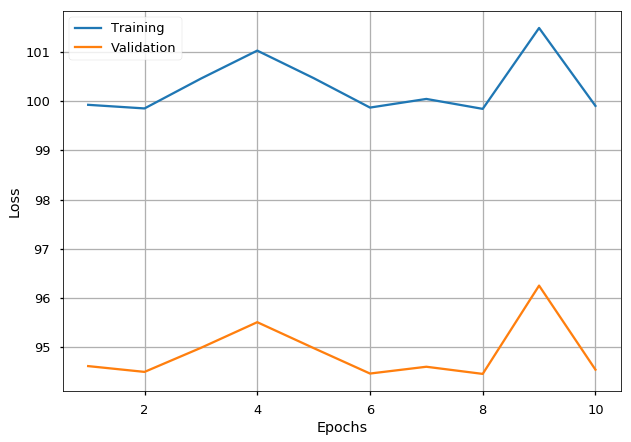

In [25]:
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, valid_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

So the model does not look exceptionally good. This is normal, we have just tried a linear model without any kind of feature engineering or transformation; we don't know for instance if the relationship between *fare_amount* and the rest of features is linear or not.

Let's try another simple model using TF, but this one will be more complex

## A more complex model

We are going to reuse a lot of code from the previous model, we will just change the kind of estimator we are using.

Let's repeat the same estimator again, and we will run it for 20 epochs this time. Then we will compare it with the new one:

In [26]:
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

epochs = np.arange(1,21)

train_loss = []
valid_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs(e)
    train_loss.append(t)
    valid_loss.append(v)

Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...
Training with 11 epochs...
Training with 12 epochs...
Training with 13 epochs...
Training with 14 epochs...
Training with 15 epochs...
Training with 16 epochs...
Training with 17 epochs...
Training with 18 epochs...
Training with 19 epochs...
Training with 20 epochs...


In [27]:
tf.logging.set_verbosity(tf.logging.ERROR)
    
def train_for_epochs_dl(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    model = tf.estimator.DNNRegressor(hidden_units=[32, 8, 2], feature_columns=feature_cols, model_dir=OUTDIR)
    model.train(tf_train)
    # name is necessary to write logs for Tensorboard
    train_loss = model.evaluate(tf_train, name=OUTDIR)['average_loss']
    valid_loss = model.evaluate(tf_valid, name=OUTDIR)['average_loss']
    
    return train_loss, valid_loss

In [28]:
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

train_dl_loss = []
valid_dl_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs_dl(e)
    train_dl_loss.append(t)
    valid_dl_loss.append(v)

Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...
Training with 11 epochs...
Training with 12 epochs...
Training with 13 epochs...
Training with 14 epochs...
Training with 15 epochs...
Training with 16 epochs...
Training with 17 epochs...
Training with 18 epochs...
Training with 19 epochs...
Training with 20 epochs...


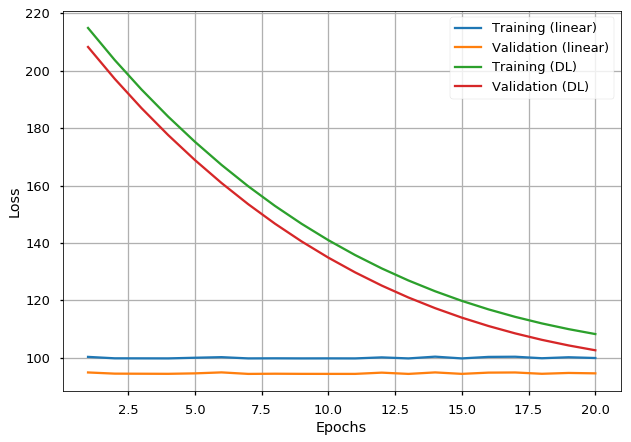

In [29]:
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training (linear)')
plt.plot(epochs, valid_loss, label='Validation (linear)')
plt.plot(epochs, train_dl_loss, label='Training (DL)')
plt.plot(epochs, valid_dl_loss, label='Validation (DL)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

Is this new model better? Why does not the linear model change with the number of epochs?

What would you do next to improve the Deep Learning model?
* Possible answers: increase the number of epochs, maybe try a more complex model. Any other hyperparam?

Let's try with 150 epochs, and see if we can beat the training and validation loss

In [30]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Let's recalculate the model, just in case we are reusing the wrong cache
tf_train = pandas2tf(df_train, 1)
tf_valid = pandas2tf(df_valid, 1)
tf_test = pandas2tf(df_test, 1)

shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

linear_model = tf.estimator.LinearRegressor(feature_columns=feature_cols, model_dir=OUTDIR)

In [31]:
# Linear benchmark (train)
linear_model.evaluate(tf_train)

{'average_loss': 229.86597,
 'label/mean': 11.403186,
 'loss': 29062.191,
 'prediction/mean': 0.0,
 'global_step': 0}

In [32]:
# Linear benchmark (validation)
linear_model.evaluate(tf_valid)

{'average_loss': 223.16864,
 'label/mean': 11.340873,
 'loss': 26969.072,
 'prediction/mean': 0.0,
 'global_step': 0}

In [33]:
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

nepochs = 150
tf_train = pandas2tf(df_train, nepochs)
tf_valid = pandas2tf(df_valid, nepochs)
  
dl_model = tf.estimator.DNNRegressor(hidden_units=[32, 8, 2], feature_columns=feature_cols, model_dir=OUTDIR)
dl_model.train(tf_train) 

In [34]:
dl_model.evaluate(tf_train)

{'average_loss': 116.1784,
 'label/mean': 11.4031925,
 'loss': 14869.727,
 'prediction/mean': 7.359625,
 'global_step': 8594}

In [35]:
dl_model.evaluate(tf_valid)

{'average_loss': 110.39849,
 'label/mean': 11.340872,
 'loss': 14123.455,
 'prediction/mean': 7.3603373,
 'global_step': 8594}

## Final decision about the models

So far, we have been ignoring the test set. We have used the validation dataset to change the hyperparameters of the model. It is now the turn to use the test set to finally decide which model is better: the linear regressor or the neural network.

For this, we can retrain the models using both the train and validation sets, with the hyperparameters that we have already decided. Then we will evaluate both models using only the test set, and we will find out which one is better predicting the test set, that is, a set of data that has not been used in any way to tune the model (the validation set has been used to tune the hyperparams, so somehow the validation set info is already included in the model).

In [36]:
tf_train = pandas2tf(df_train, 1)
tf_valid = pandas2tf(df_valid, 1)
tf_test = pandas2tf(df_test, 1)

shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

linear_model = tf.estimator.LinearRegressor(feature_columns=feature_cols, model_dir=OUTDIR)
linear_model.evaluate(tf_test)

{'average_loss': 213.31387,
 'label/mean': 11.104377,
 'loss': 25794.57,
 'prediction/mean': 0.0,
 'global_step': 0}

In [37]:
tf_train = pandas2tf(df_train, 150)
tf_valid = pandas2tf(df_valid, 150)
tf_test = pandas2tf(df_test, 150)

shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
dl_model = tf.estimator.DNNRegressor(hidden_units=[32, 8, 2], feature_columns=feature_cols, model_dir=OUTDIR)
dl_model.evaluate(tf_test)

{'average_loss': 213.31395,
 'label/mean': 11.104381,
 'loss': 27292.148,
 'prediction/mean': 0.0,
 'global_step': 0}

So the Deep Learning model can predict the taxi fare with a lower MSRE